# Day x
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian, SWA renwal test

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
#os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17409709224288765896
]


## Options

In [3]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(dirLoc + 'inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)

In [5]:
trainData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"),
                                    inputPipe=inputPipe, augRotMult=16)

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.682s 


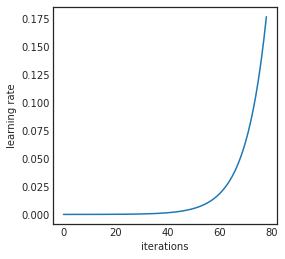

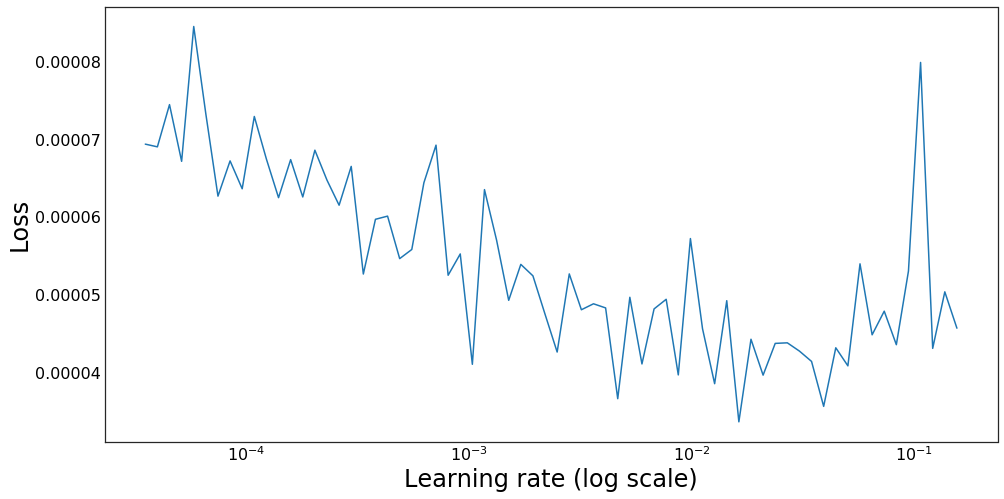

______________________________________



In [6]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,2e-1], trainOnWeights=True, verbose=0)

In [7]:
compileArgs['lr'] = 1e-3

In [8]:
def _batchTrainClassifier(batchYielder, nSplits, modelGen, modelGenParams, trainParams,
                         cosAnnealMult=0, reverseAnneal=False, plotLR=False, reduxDecay=False,
                         annealMomentum=False, reverseAnnealMomentum=False, plotMomentum=False,
                         oneCycle=False, ratio=0.25, reverse=False, lrScale=10, momScale=10, plotOneCycle=False, scale=30, mode='sgd',
                         swaStart=-1, swaRenewal=-1,
                         trainOnWeights=True,
                         saveLoc='train_weights/', patience=10, maxEpochs=10000,
                         verbose=False, logoutput=False):
    
    os.system("mkdir " + saveLoc)
    os.system("rm " + saveLoc + "*.h5")
    os.system("rm " + saveLoc + "*.json")
    os.system("rm " + saveLoc + "*.pkl")
    os.system("rm " + saveLoc + "*.png")
    os.system("rm " + saveLoc + "*.log")
    
    if logoutput:
        old_stdout = sys.stdout
        log_file = open(saveLoc + 'training_log.log', 'w')
        sys.stdout = log_file

    start = timeit.default_timer()
    results = []
    histories = []
    binary = None

    if not isinstance(batchYielder, BatchYielder):
        print ("HDF5 as input is depreciated, converting to BatchYielder")
        batchYielder = BatchYielder(batchYielder)

    if cosAnnealMult: print ("Using cosine annealing")
    if trainOnWeights: print ("Training using weights")

    for fold in range(nSplits):
        foldStart = timeit.default_timer()
        print ("Running fold", fold+1, "/", nSplits)
        os.system("rm " + saveLoc + "best.h5")
        best = -1
        bestLR = -1
        reduxDecayActive = False
        tmpPatience = patience
        epochCounter = 0
        subEpoch = 0
        stop = False
        lossHistory = {'val_loss':[], 'swa_val_loss':[]}
        trainID, testID = getFolds(fold, nSplits) #Get fold indeces for training and testing for current fold

        model = None
        model = modelGen(**modelGenParams)
        model.reset_states #Just checking
        
        testbatch = batchYielder.getBatch(testID) #Load testing fold

        callbacks = []
        if cosAnnealMult:
            cosAnneal = CosAnneal(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnneal)
            callbacks.append(cosAnneal)
        
        if annealMomentum:
            cosAnnealMomentum = CosAnnealMomentum(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnnealMomentum)
            callbacks.append(cosAnnealMomentum)    

        if oneCycle:
            oneCycle = OneCycle(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), ratio=ratio, reverse=reverse, lrScale=lrScale, momScale=momScale, scale=scale, mode=mode)
            callbacks.append(oneCycle)  
        
        if swaStart >= 0:
            if cosAnnealMult:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, cosAnneal, trainOnWeights=trainOnWeights)
            else:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, trainOnWeights=trainOnWeights)
            callbacks.append(swa)
        useSWA = False

        for epoch in range(maxEpochs):
            for n in trainID: #Loop through training folds
                trainbatch = batchYielder.getBatch(n) #Load fold data
                subEpoch += 1
                
                if binary == None: #First run, check classification mode
                    binary = True
                    nClasses = len(np.unique(trainbatch['targets']))
                    if nClasses > 2:
                        print (nClasses, "classes found, running in multiclass mode\n")
                        trainbatch['targets'] = utils.to_categorical(trainbatch['targets'], num_classes=nClasses)
                        binary = False
                    else:
                        print (nClasses, "classes found, running in binary mode\n")

                if trainOnWeights:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto', sample_weight=trainbatch['weights'],
                              callbacks = callbacks, **trainParams) #Train for one epoch

                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                        
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], sample_weight=testbatch['weights'], verbose=0)
                    
                else:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto',
                              callbacks = callbacks, **trainParams) #Train for one epoch
                    
                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], verbose=0)
                
                if swaStart >= 0 and swa.active and cosAnnealMult > 1:
                    print ("{} SWA loss:", subEpoch, loss)
                
                if swaStart >= 0:
                    if swa.active:
                        lossHistory['swa_val_loss'].append(losses['swa'])
                        lossHistory['val_loss'].append(losses['base'])
                    else:
                        lossHistory['swa_val_loss'].append(loss)
                        lossHistory['val_loss'].append(loss)
                        

                if loss <= best or best < 0: #Save best
                    best = loss
                    if cosAnnealMult:
                        if cosAnneal.lrs[-1] > 0:
                            bestLR = cosAnneal.lrs[-1]
                        else:
                            bestLR = cosAnneal.lrs[-2]
                    epochCounter = 0
                    if swaStart >= 0 and swa.active and useSWA:
                        swa.test_model.save_weights(saveLoc + "best.h5")
                    else:
                        model.save_weights(saveLoc + "best.h5")
                    if reduxDecayActive:
                        cosAnneal.lrs.append(float(K.get_value(model.optimizer.lr)))
                    if verbose:
                        print ('{} New best found: {}'.format(subEpoch, best))
                elif cosAnnealMult and not reduxDecayActive:
                    if cosAnneal.cycle_end:
                        epochCounter += 1
                else:
                    epochCounter += 1
                    if reduxDecayActive:
                        lr = 0.8*float(K.get_value(model.optimizer.lr))
                        cosAnneal.lrs.append(lr)
                        K.set_value(model.optimizer.lr, lr)

                if epochCounter >= tmpPatience: #Early stopping
                    if cosAnnealMult and reduxDecay and not reduxDecayActive:
                        print ('CosineAnneal stalling after {} epochs, entering redux decay at LR={}'.format(subEpoch, bestLR))
                        model.load_weights(saveLoc +  "best.h5")
                        cosAnneal.lrs.append(bestLR)
                        K.set_value(model.optimizer.lr, bestLR)
                        tmpPatience = 10
                        epochCounter = 0
                        callbacks = []
                        reduxDecayActive = True
                    else:
                        if verbose:
                            print ('Early stopping after {} epochs'.format(subEpoch))
                        stop = True
                        break
            
            if stop:
                break

        model.load_weights(saveLoc +  "best.h5")

        histories.append({})
        histories[-1]['val_loss'] = lossHistory['val_loss']
        if swaStart >= 0:
            histories[-1]['swa_val_loss'] = lossHistory['swa_val_loss']
        
        results.append({})
        results[-1]['loss'] = best
        if binary:
            testbatch = batchYielder.getBatch(testID) #Load testing fold
            if not isinstance(testbatch['weights'], type(None)):
                results[-1]['wAUC'] = 1-roc_auc_score(testbatch['targets'],
                                                     model.predict(testbatch['inputs'], verbose=0),
                                                     sample_weight=testbatch['weights'])
            results[-1]['AUC'] = 1-roc_auc_score(testbatch['targets'],
                                                 model.predict(testbatch['inputs'], verbose=0))
        print ("Score is:", results[-1])

        if plotLR: cosAnneal.plot_lr()
        if plotMomentum: cosAnnealMomentum.plot_momentum()
        if plotOneCycle: oneCycle.plot()

        print("Fold took {:.3f}s\n".format(timeit.default_timer() - foldStart))

        model.save(saveLoc +  'train_' + str(fold) + '.h5')
        with open(saveLoc +  'resultsFile.pkl', 'wb') as fout: #Save results
            pickle.dump(results, fout)

    print("\n______________________________________")
    print("Training finished")
    print("Cross-validation took {:.3f}s ".format(timeit.default_timer() - start))
    plotTrainingHistory(histories, save=saveLoc + 'loss_history.png')
    for score in results[0]:
        mean = uncertRound(np.mean([x[score] for x in results]), np.std([x[score] for x in results])/np.sqrt(len(results)))
        print ("Mean", score, "= {} +- {}".format(mean[0], mean[1]))
    print("______________________________________\n")
                      
    if logoutput:
        sys.stdout = old_stdout
        log_file.close()
    return results, histories

In [9]:
class _SWA(Callback):
    '''Based on fastai version'''
    def __init__(self, swa_start, testBatch, testModel, verbose=False, swaRenewal=-1,
                 clrCallback=None, trainOnWeights=False, sgdReplacement=False):
        super(_SWA, self).__init__()
        self.swa_model = None
        self.swa_model_new = None
        self.swa_start = swa_start
        self.epoch = -1
        self.swa_n = -1
        self.swaRenewal = swaRenewal
        self.n_since_renewal = -1
        self.losses = {'swa':None, 'base':None}
        self.active = False
        self.testBatch = testBatch
        self.weighted = trainOnWeights
        self.clrCallback = clrCallback
        self.test_model = testModel
        self.verbose = verbose
        
    def on_train_begin(self, logs={}):
        if isinstance(self.swa_model, type(None)):
            self.swa_model = self.model.get_weights()
            self.swa_model_new = self.model.get_weights()
            self.epoch = 0
            self.swa_n = 0
            self.n_since_renewal = 0
            self.first_completed= False
            self.cylcle_since_replacement = 1
            
    def on_epoch_begin(self, metrics, logs={}):
        self.losses = {'swa':None, 'base':None}

    def on_epoch_end(self, metrics, logs={}):
        if (self.epoch + 1) >= self.swa_start and (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end):
            if self.swa_n == 0:
                print ("SWA beginning")
                self.active = True
            elif not isinstance(self.clrCallback, type(None)) and self.clrCallback.cycle_mult > 1:
                print ("Updating average")
                self.active = True
            self.update_average_model()
            self.swa_n += 1
            
            if self.swa_n > self.swaRenewal:
                self.first_completed = True
                self.n_since_renewal += 1
                if self.n_since_renewal > self.cylcle_since_replacement*self.swaRenewal and self.swaRenewal > 0:
                    self.compareAverages()
            
        if isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end:
            self.epoch += 1

        if self.active and not (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end or self.clrCallback.cycle_mult == 1):
            self.active = False
            
    def update_average_model(self):
        # update running average of parameters
        print("model is {} epochs old".format(self.swa_n))
        for model_param, swa_param in zip(self.model.get_weights(), self.swa_model):
            swa_param *= self.swa_n
            swa_param += model_param
            swa_param /= (self.swa_n + 1)
        
        if self.swa_n > self.swaRenewal and self.first_completed:
            print("new model is {} epochs old".format(self.n_since_renewal))
            for model_param, swa_param in zip(self.model.get_weights(), self.swa_model_new):
                swa_param *= self.n_since_renewal
                swa_param += model_param
                swa_param /= (self.n_since_renewal + 1)
            
    def compareAverages(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        self.test_model.set_weights(self.swa_model_new)
        if self.weighted:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
        else:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        print("Checking renewal swa model, current model: {}, new model: {}".format(self.losses['swa'], new_loss))
        if new_loss < self.losses['swa']:
            print("New model better, replacing\n____________________\n\n")
            self.losses['swa'] = new_loss
            if sgdReplacement:
                self.model.set_weights(self.swa_model)
                self.n_since_renewal = 0
            else:
                self.n_since_renewal = 1
            self.swa_model[:] = self.swa_model_new
            self.swa_model_new = self.model.get_weights()
            self.swa_n = self.n_since_renewal
            self.cylcle_since_replacement = 1

        else:
            print("Current model better, renewing\n____________________\n\n")
            self.swa_model_new = self.model.get_weights()
            self.n_since_renewal = 1
            self.test_model.set_weights(self.swa_model)
            self.cylcle_since_replacement += 1
                
    
    def get_losses(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        if isinstance(self.losses['base'], type(None)):
            if self.weighted:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        return self.losses

## Train classifier

Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 4.018765703666736e-05
2 New best found: 3.672098628876902e-05
3 New best found: 3.594355392613191e-05
5 New best found: 3.5605665907124624e-05
6 New best found: 3.52423955972995e-05
8 New best found: 3.481898547914163e-05
10 New best found: 3.430284167317107e-05
12 New best found: 3.4126777557833365e-05
14 New best found: 3.3951229960161143e-05
16 New best found: 3.390347590443621e-05
19 New best found: 3.382278532261598e-05
22 New best found: 3.36944709896377e-05
23 New best found: 3.358957386078455e-05
28 New best found: 3.3581459588467844e-05
30 New best found: 3.343384183247708e-05
33 New best found: 3.3430330131423036e-05
35 New best found: 3.341115184751044e-05
39 New best found: 3.312635023904597e-05
63 New best found: 3.30813821162201e-05
66 New best found: 3.300942811426749e-05
70 New best found: 3.2881516238356065e-05
73 New best found: 3.287266610515787e-05
105 New best foun

7 New best found: 3.4371830549207514e-05
9 New best found: 3.421117149846396e-05
10 New best found: 3.419851686630864e-05
11 New best found: 3.348294204479316e-05
17 New best found: 3.343146770057501e-05
19 New best found: 3.3179544092854486e-05
20 New best found: 3.3155926411563995e-05
24 New best found: 3.28083917251206e-05
33 New best found: 3.274736902967561e-05
34 New best found: 3.256609188683797e-05
44 New best found: 3.242464130889857e-05
56 New best found: 3.234680833702441e-05
61 New best found: 3.219489952462027e-05
69 New best found: 3.2149843314255125e-05
71 New best found: 3.194753682182636e-05
87 New best found: 3.185993369988864e-05
111 New best found: 3.1817015637352596e-05
133 New best found: 3.17411538795568e-05
142 New best found: 3.166061859956244e-05
Early stopping after 192 epochs
Score is: {'loss': 3.166061859956244e-05, 'wAUC': 0.0633723995877018, 'AUC': 0.10140208319746713}
Fold took 223.739s

Running fold 8 / 10
1 New best found: 4.017869495429709e-05
2 New b

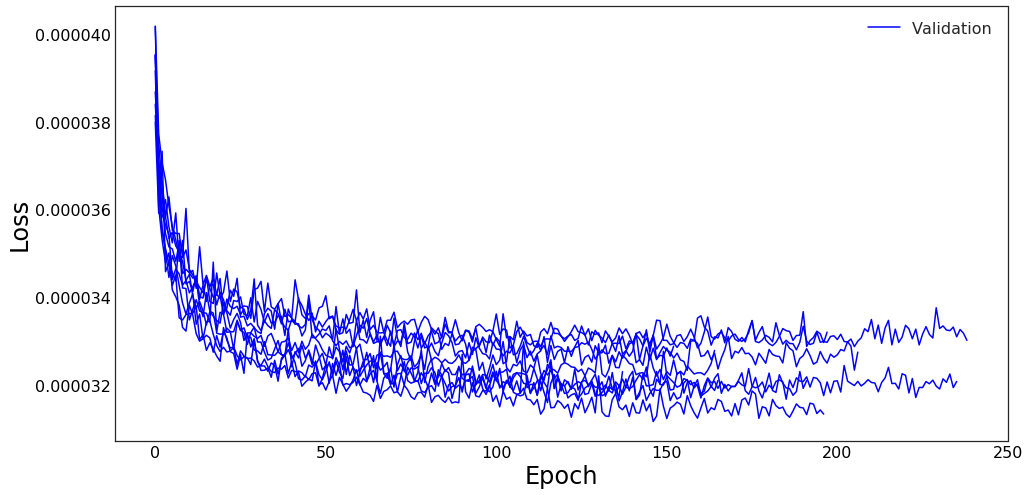

Mean loss = 3.2e-05 +- 2e-07
Mean wAUC = 0.0646 +- 0.0007
Mean AUC = 0.102 +- 0.001
______________________________________



<Figure size 432x288 with 0 Axes>

In [11]:
results, histories = batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams, swaStart=-1,
                                          patience=50, cosAnnealMult=0, reduxDecay=False, trainOnWeights=True,
                                          maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on val data

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=16)

In [ ]:
pred = []
for i in xrange(10):
    tmpPred = []
    for aug in range(valData.augMult):
        batch = valData.getTestBatch(i, aug)['inputs']
        tmpPred.append(ensemblePredict(batch, ensemble, weights, n=1))
    pred.append(np.array(tmpPred))

In [ ]:
tPred = np.concatenate(pred, axis=1)

In [ ]:
df = pandas.DataFrame(getFeature('targets', valData.source), columns=['target'])

In [ ]:
for p in xrange(tPred.shape[0]):
    df['pred_'+ str(p)] = tPred[p,:]

In [ ]:
df.loc[:,'pred_mean'] = np.mean(df[[x for x in df.columns if 'pred' in x]], axis=1)

### Rot 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### Ref

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 4

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 10

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 16

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

In [ ]:
def amsScanQuick(inData, wFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

## Response on validation data base

In [ ]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Ref

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 6

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=6)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=10)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 3

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=3)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

# Final run

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=5, verbose=1)

In [ ]:
saveTest(0.9632657, 'Day_10_basic_rotref8_5')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_basic_rotref8_5_test.csv -m"Day_10 basic rotref8 5"

## Response on validation data Rot-Ref 8 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
cut = amsScanQuick(convertToDF(valData.source))[1]

In [ ]:
trainFrame = pandas.DataFrame()
trainFrame['gen_target'] = getFeature('targets', trainData.source)
trainFrame['gen_weight'] = getFeature('weights', trainData.source)
valFrame = convertToDF(valData.source)

In [ ]:
sigFactor = (len(trainFrame.loc[trainFrame.gen_target == 1, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight'])
bkgFactor = (len(trainFrame.loc[trainFrame.gen_target == 0, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight'])
print sigFactor, bkgFactor

In [ ]:
def amsScanQuick(inData, sigFactor=250000./50000., bkgFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * sigFactor),max(0,b * bkgFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

In [ ]:
amsScanQuick(valFrame, sigFactor, bkgFactor)

In [ ]:
def amsScan(inData, scale=False):
    best = [0,-1]
    ams = []
    for index, row in inData.iterrows():
        s = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 1), 'gen_weight'])
        b = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 0), 'gen_weight'])
        ams.append(AMS(s, b))
        if ams[-1] > best[1]:
            best = [row['pred_class'], ams[-1]]
    print best
    return ams, best

def foldAMSScan(inData, N=10):
    kf = StratifiedKFold(n_splits=N, shuffle=True)
    folds = kf.split(inData, inData['gen_target'])
    bests = []
    for i, (train, test) in enumerate(folds):
        bests.append(amsScan(inData.iloc[test], (np.sum(inData[(inData['gen_target'] == 1)]['gen_weight']), np.sum(inData[(inData['gen_target'] == 0)]['gen_weight'])))[1])
        print "Fold {}, best AMS {} at cut of {}. Total weights Signal:Bkg. {}:{}".format(i, bests[-1][1], bests[-1][0],
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))
    print "Mean cut", np.average([x[0] for x in bests], weights=[1/x[1] for x in bests]), "mean AMS", np.average([x[1] for x in bests], weights=[1/x[1] for x in bests])
    return bests

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print np.average([x[0] for x in bests])
print np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1.7448610687361392-x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1/np.abs(1.7448610687361392-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.9557010754710975, 'Day_10_M_rotref8_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_M_rotref8_10_test.csv -m"Day_10 minus rotref8 10"

## Response on validation data Rot-Ref 16 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print 'Mean', np.average([x[0] for x in bests])
print 'Inverse-AMS-weighted mean', np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print 'AMS-weighted mean', np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print 'AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1.7472080023156094-x[1] for x in bests])
print 'Inverse AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1/np.abs(1.7472080023156094-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.95, 'Day_10_95_rotref16_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_95_rotref16_10_test.csv -m"Day_10 95 rotref16 10"